In [1]:
import io
import torch
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image as IPythonImage
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

np.set_printoptions(linewidth=200)
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:
imageWidth = 512    
imageHeight = 512                                         
guidance_scale = 8                                                             
model_path = "segmind/tiny-sd" 

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)
scheduler = LMSDiscreteScheduler.from_pretrained(model_path, subfolder="scheduler")
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet").to(torch_device)
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae").to(torch_device)

In [3]:
def get_text_embeddings(prompt, tokenizer=tokenizer, text_encoder=text_encoder, torch_device=torch_device, batch_size=1):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    return text_embeddings

In [4]:
def generate_latents(seed, height=imageHeight, width=imageWidth, torch_device=torch_device, unet=unet, batch_size=1):
    generator = torch.Generator().manual_seed(int(seed))
    
    latents = torch.randn(
      (batch_size, unet.config.in_channels, height // 8, width // 8),
      generator=generator,
    ).to(torch_device)

    return latents

In [5]:
def convert_to_pil_image(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

In [6]:
def generate_images(latents, text_embeddings, num_inference_steps, unet=unet, guidance_scale=guidance_scale, vae=vae, scheduler=scheduler, intermediate=False):
    scheduler.set_timesteps(num_inference_steps)
    latents = latents * scheduler.init_noise_sigma
    images = []
    
    for t in tqdm(scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        if intermediate:
            Latents = 1 / 0.18215 * latents
            with torch.no_grad():
                image = vae.decode(Latents).sample
            images.append(convert_to_pil_image(image))

        latents = scheduler.step(noise_pred, t, latents).prev_sample    

    if not intermediate:
        Latents = 1 / 0.18215 * latents
        with torch.no_grad():
            image = vae.decode(Latents).sample
        images = convert_to_pil_image(image)

    return images

In [7]:
def display_circular_images(prompt, seed, num_inference_steps, num_images, degree):
    np.random.seed(seed)
    text_embeddings = get_text_embeddings(prompt)

    latents_x = generate_latents(seed)
    latents_y = generate_latents(seed*np.random.randint(0,100000))

    scale_x = torch.cos(torch.linspace(0, 2, num_images)*torch.pi*(degree/360)).to(torch_device)
    scale_y = torch.sin(torch.linspace(0, 2, num_images)*torch.pi*(degree/360)).to(torch_device)

    noise_x = torch.tensordot(scale_x, latents_x, dims=0)
    noise_y = torch.tensordot(scale_y, latents_y, dims=0)

    noise = noise_x + noise_y

    images = []
    for i in range(num_images):   
        image = generate_images(noise[i], text_embeddings, num_inference_steps)
        images.append((image,i+1))

    return images   

In [8]:
def export_as_gif(images, frames_per_second=10):
    gif = io.BytesIO()

    images[0].save(
        gif,
        format="GIF",
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )
    gif.seek(0)
    return gif

In [9]:
prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k"
num_images = 5                      
degree = 360               
num_inference_steps = 8            
seed = 69420                       

In [11]:
images = display_circular_images(prompt, seed, num_inference_steps, num_images, degree)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

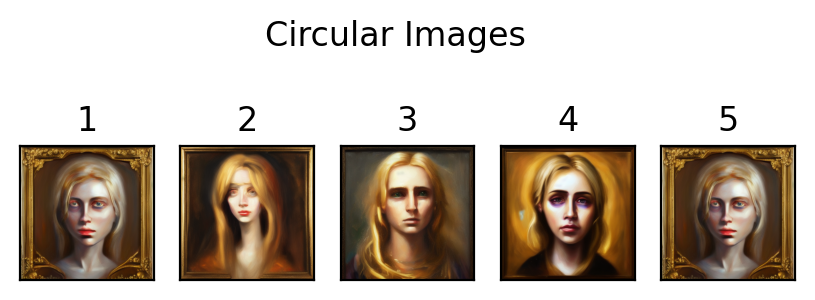

In [12]:
fig, ax = plt.subplots(1, num_images, dpi=200, figsize=(num_images, 2))
fig.suptitle("Circular Images")

for i in range(num_images):
    ax[i].imshow(images[i][0])
    ax[i].set_title(images[i][1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

In [13]:
gif = export_as_gif(
        [img[0] for img in images],
        frames_per_second=2
        )

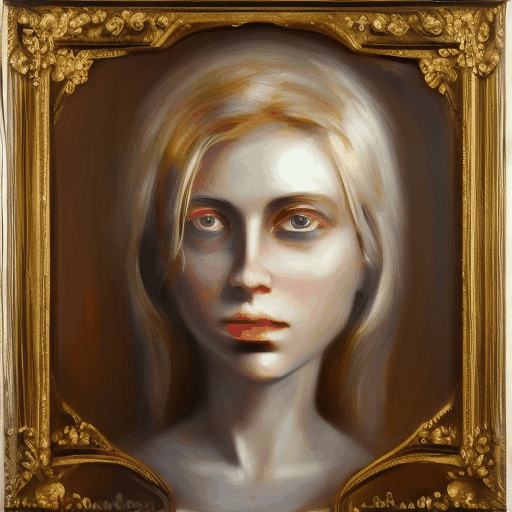

In [14]:
IPythonImage(data=gif.getvalue())